In [1]:
from IPython.display import Image

<hr>

This is the code from [the onnx documentation](https://onnx.ai/onnx/intro/python.html).

This notebooks talks about manipulating ONNX models with the Python API.

<hr>

## Creating Model

Linear expression: `Y = A * X + B`

In [2]:
from onnx import TensorProto
from onnx.helper import (
    make_model, make_node, make_graph, make_tensor_value_info,
    tensor_dtype_to_np_dtype
)
from onnx.checker import check_model

### Declearing Variables

We use the `make_tensor_value_info` to declare variables.

In [3]:
X = make_tensor_value_info(
    name="X", elem_type=TensorProto.FLOAT, shape=[None, None]
)

A = make_tensor_value_info(
    name="A", elem_type=TensorProto.FLOAT, shape=[None, None]
)

B = make_tensor_value_info(
    name="B", elem_type=TensorProto.FLOAT, shape=[None, None]
)

Y = make_tensor_value_info(
    name="Y", elem_type=TensorProto.FLOAT, shape=[None]
)

### Declaring Operators

Operats are the "nodes" in the computation graph of a neural network.

We use the `make_node` function to declare nodes.

In [4]:
node_1 = make_node(
    op_type='MatMul', inputs=['X', 'A'], outputs=['XA'],
)

node_2 = make_node(
    op_type='Add', inputs=['XA', 'B'], outputs=['Y'],
)

### Declaring the Graph

We can construct the computational graph with the `make_graph` function.

In [5]:
graph = make_graph(
    nodes=[node_1, node_2],
    name="linear regression",
    inputs=[X, A, B],
    outputs=[Y],
)

### Creating a model

We can convert the computation Graph to ONNX model via `make_model` function.

We can use `check_model` to ensure our result being legitimate.

In [6]:
model = make_model(graph)

check_model(model)

### Save the Model

We **serialise** the model with the `SerializePartialToString` method.

In [7]:
with open("model_lr.onnx", "wb") as f:
    f.write(model.SerializePartialToString())

We can visualise the model with tools such as Netron, yielding an image like this,

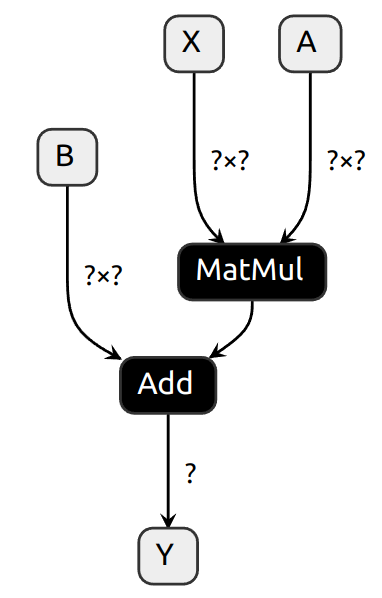

In [8]:
Image("model_lr.png", width=150)

## Parsing a Model

### Loading the model

We can use the `load` function to load a model as the ONNX representation, `onnx.onnx_ml_pb2.ModelProto`.

In [9]:
from onnx import load

model = load("./model_lr.onnx")
type(model)

onnx.onnx_ml_pb2.ModelProto

### Inspecting the IO details

The following code shows the way to print inputs and outputs of a model.

Notice the helpful fucntions

- `onnx.helper.tensor_dtype_to_np_dtype`.
- our own `get_tensor_shape`

In [10]:
def get_tensor_shape(tensor):
    shape = tensor.type.tensor_type.shape
    return tuple(getattr(d, 'dim_value', 0) for d in shape.dim)

for obj in model.graph.input:
    name  = obj.name
    dtype = tensor_dtype_to_np_dtype(
        obj.type.tensor_type.elem_type
    )
    shape = get_tensor_shape(obj)
    print("Input  tensor:", name, shape, dtype)
    
for obj in model.graph.output:
    name  = obj.name
    dtype = tensor_dtype_to_np_dtype(
        obj.type.tensor_type.elem_type
    )
    shape = get_tensor_shape(obj)
    print("Output tensor:", name, shape, dtype)

Input  tensor: X (0, 0) float32
Input  tensor: A (0, 0) float32
Input  tensor: B (0, 0) float32
Output tensor: Y (0,) float32


### Inspecting Operators

The following code shows how to extract information of computational nodes.

By doing so, we clearly see the flow of computation in the Graph.

In [11]:
for node in model.graph.node:
    name = node.name
    op = node.op_type
    tensor_in = node.input
    tensor_out = node.output
    print(f"Node {name}:", tensor_in, "->", op, "->", tensor_out)

Node : ['X', 'A'] -> MatMul -> ['XA']
Node : ['XA', 'B'] -> Add -> ['Y']
